In [35]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import tensorflow as tf
import tensorflow.keras
import keras.backend as K

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from glob import glob
from PIL import Image
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
# import os

In [36]:
# my_glob = glob('/kaggle/input/chexpert/CheXpert-v1.0-small/train/patient*/study*/*.jpg')
# print('Number of Observations: ', len(my_glob)) 

In [37]:
train_df = pd.read_csv('/kaggle/input/chexpert/CheXpert-v1.0-small/train.csv')
print(f'the shape of the training dataset is : {train_df.shape}')
train_df.head()

the shape of the training dataset is : (223414, 19)


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [38]:
train_df['Path'] = '/kaggle/input/chexpert/' + train_df['Path'].astype(str)

In [39]:
# 'CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg'
train_df['Path'][0] 


'/kaggle/input/chexpert/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg'

In [40]:
train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,/kaggle/input/chexpert/CheXpert-v1.0-small/tra...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [41]:
def prepare_dataset(dataframe,policy,class_names):
    dataset_df = dataframe[dataframe['Frontal/Lateral'] == 'Frontal'] #take frontal pics only
    df = dataset_df.sample(frac=1., random_state=1)
    df.fillna(0, inplace=True) #fill the with zeros
    x_path, y_df = df["Path"].to_numpy(), df[class_names]
    class_ones = ['Atelectasis', 'Cardiomegaly']
    y = np.empty(y_df.shape, dtype=int)
    for i, (index, row) in enumerate(y_df.iterrows()):
        labels = []
        for cls in class_names:
            curr_val = row[cls]
            feat_val = 0
            if curr_val:
                curr_val = float(curr_val)
                if curr_val == 1:
                    feat_val = 1
                elif curr_val == -1:
                    if policy == "ones":
                        feat_val = 1
                    elif policy == "zeroes":
                        feat_val = 0
                    elif policy == "mixed":
                        if cls in class_ones:
                            feat_val = 1
                        else:
                            feat_val = 0
                    else:
                        feat_val = 0
                else:
                    feat_val = 0
            else:
                feat_val = 0
            
            labels.append(feat_val)
            
        y[i] = labels
        
    return x_path,y

In [42]:
class_names = ['Atelectasis', 'Pneumothorax', 'Consolidation', 'Edema', 'Pleural Effusion']
policy = ['ones','zeroes','mixed']
x_path,labels = prepare_dataset(train_df,policy[-1],class_names)

In [43]:
train_df = pd.DataFrame({'path':x_path})
df2 = pd.DataFrame(labels,columns=class_names)
train_df[list(df2.columns)]=df2 

Pleural Effusion    76899
Atelectasis         59583
Edema               49675
Pneumothorax        17693
Consolidation       12983
dtype: int64


(<AxesSubplot:ylabel='0'>,
 (array([0, 1, 2, 3, 4]),
  [Text(0, 0, 'Pleural Effusion'),
   Text(1, 0, 'Atelectasis'),
   Text(2, 0, 'Edema'),
   Text(3, 0, 'Pneumothorax'),
   Text(4, 0, 'Consolidation')]))

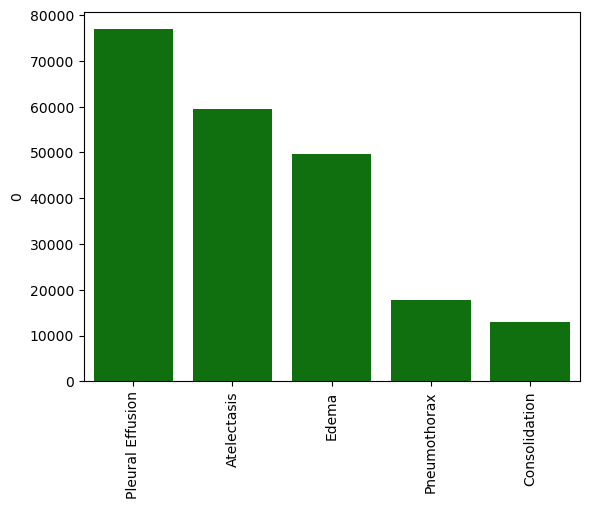

In [44]:
clean_labels = train_df[class_names].sum().sort_values(ascending= False) # get sorted value_count for clean labels
print(clean_labels) # view tabular results

# plot cases using seaborn barchart
clean_labels_df = clean_labels.to_frame() # convert to dataframe for plotting purposes
sns.barplot(x = clean_labels_df.index[::], y= 0, data = clean_labels_df[::], color = "green"), plt.xticks(rotation = 90) # visualize results graphically

In [45]:
valid_df = pd.read_csv('/kaggle/input/chexpert/CheXpert-v1.0-small/valid.csv')
print(f'the shape of the validation dataset is : {valid_df.shape}')
valid_df.head()

the shape of the validation dataset is : (234, 19)


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
valid_df['Path'] = '/kaggle/input/chexpert/' + valid_df['Path'].astype(str)
valid_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,/kaggle/input/chexpert/CheXpert-v1.0-small/val...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/kaggle/input/chexpert/CheXpert-v1.0-small/val...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,/kaggle/input/chexpert/CheXpert-v1.0-small/val...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,/kaggle/input/chexpert/CheXpert-v1.0-small/val...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/kaggle/input/chexpert/CheXpert-v1.0-small/val...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# my_glob_valid = glob('/kaggle/input/chexpert/CheXpert-v1.0-small/valid/patient*/study*/*.jpg')
# print('Number of Observations: ', len(my_glob_valid)) 

In [48]:
valid_x_path,valid_labels = prepare_dataset(valid_df,policy[-1],class_names)

In [49]:
valid_df = pd.DataFrame({'path':valid_x_path})
df2_valid = pd.DataFrame(valid_labels,columns=class_names)
valid_df[list(df2.columns)]=df2_valid

In [50]:
IMG_SIZE = (224,224)
CHANNELS = 1

In [51]:
# base_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
#                                                            shear_range=0.2,
#                                                            zoom_range=0.2,
#                                                            rotation_range=20,
#                                                            width_shift_range=0.2,
#                                                            height_shift_range=0.2,
#                                                            horizontal_flip=True)

# train_gen = base_gen.flow_from_dataframe(dataframe=train_df,
#                                          directory=None,
#                                          x_col='path',
#                                          y_col=class_names,
#                                          class_mode='raw',
#                                          target_size=IMG_SIZE,
#                                          shuffle=True,
#                                          color_mode = 'grayscale',
#                                          batch_size=16)

# valid_gen = base_gen.flow_from_dataframe(dataframe=valid_df,
#                                          directory=None,
#                                          x_col='path',
#                                          y_col=class_names,
#                                          class_mode='raw',
#                                          target_size=IMG_SIZE,
#                                          shuffle = True,
#                                          #color_mode = 'grayscale',
#                                          batch_size=16)  # we can use much larger batches for evaluation


# test_X, test_Y = next(base_gen.flow_from_dataframe(dataframe=valid_df,
#                                                    directory=None,
#                                                    x_col='path',
#                                                    y_col=class_names,
#                                                    class_mode='raw',
#                                                    target_size=IMG_SIZE,
#                                                    shuffle = True,
#                                                    #color_mode = 'grayscale',
#                                                    batch_size=16))

Found 191027 validated image filenames.
Found 202 validated image filenames.
Found 202 validated image filenames.


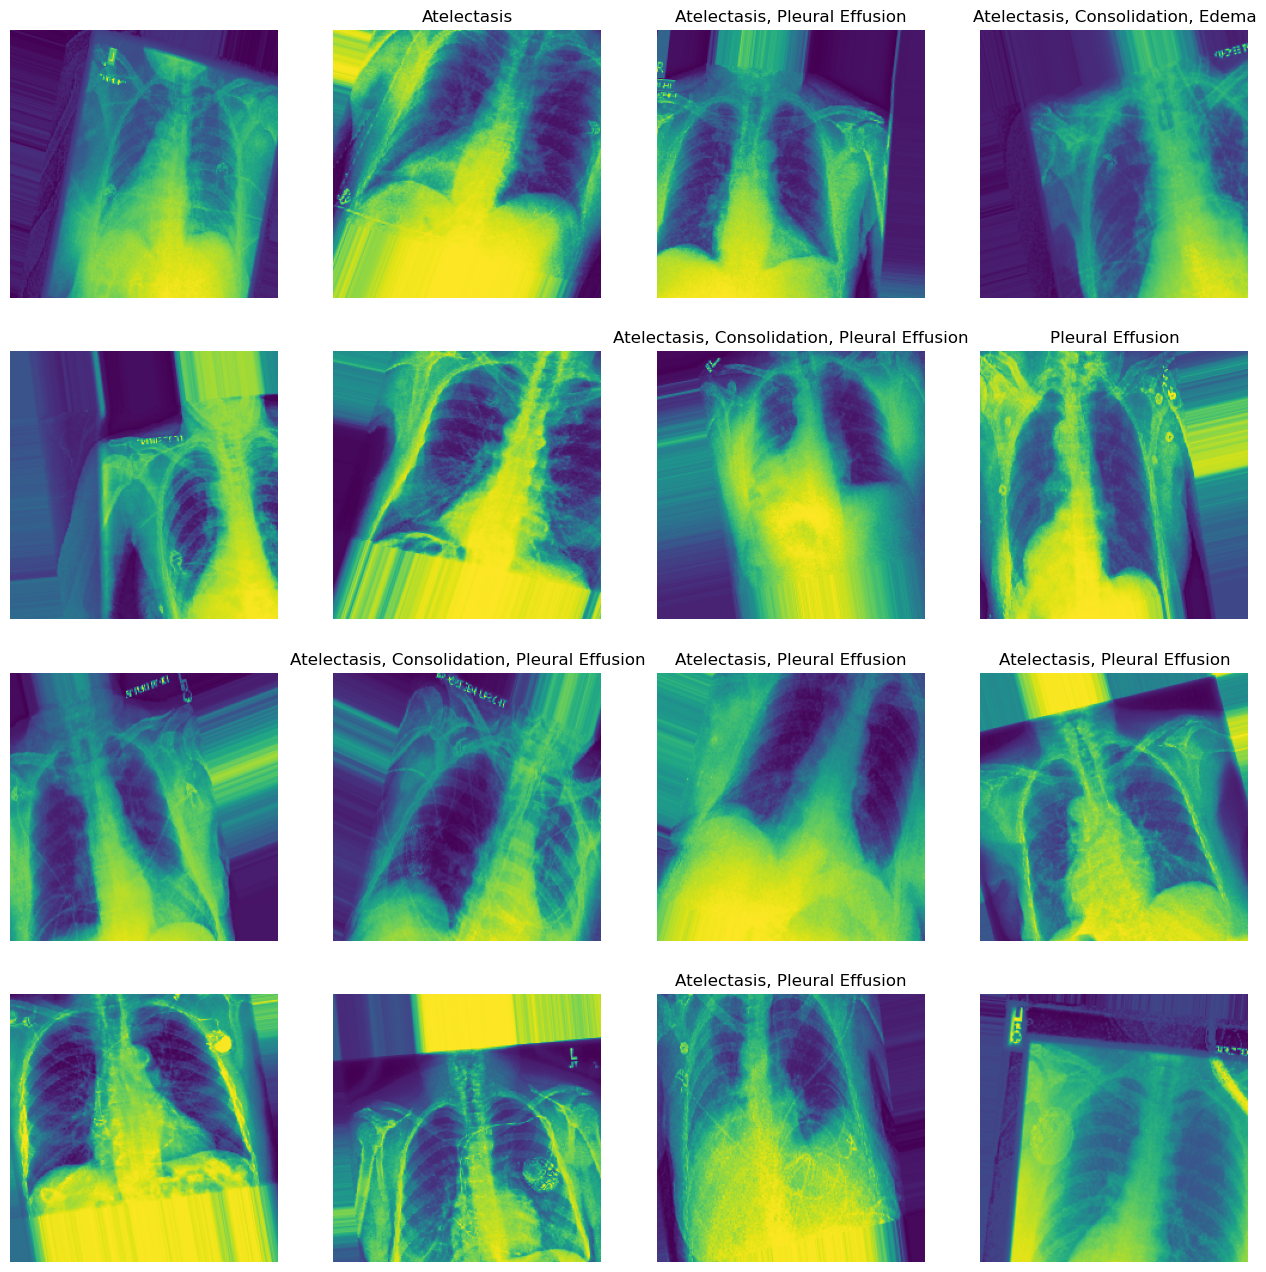

In [52]:
# t_x, t_y = next(valid_gen)
# fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
# for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0])
#     c_ax.set_title(', '.join([n_class for n_class, n_score in zip(class_names, c_y) 
#                              if n_score>0.5]))
#     c_ax.axis('off')

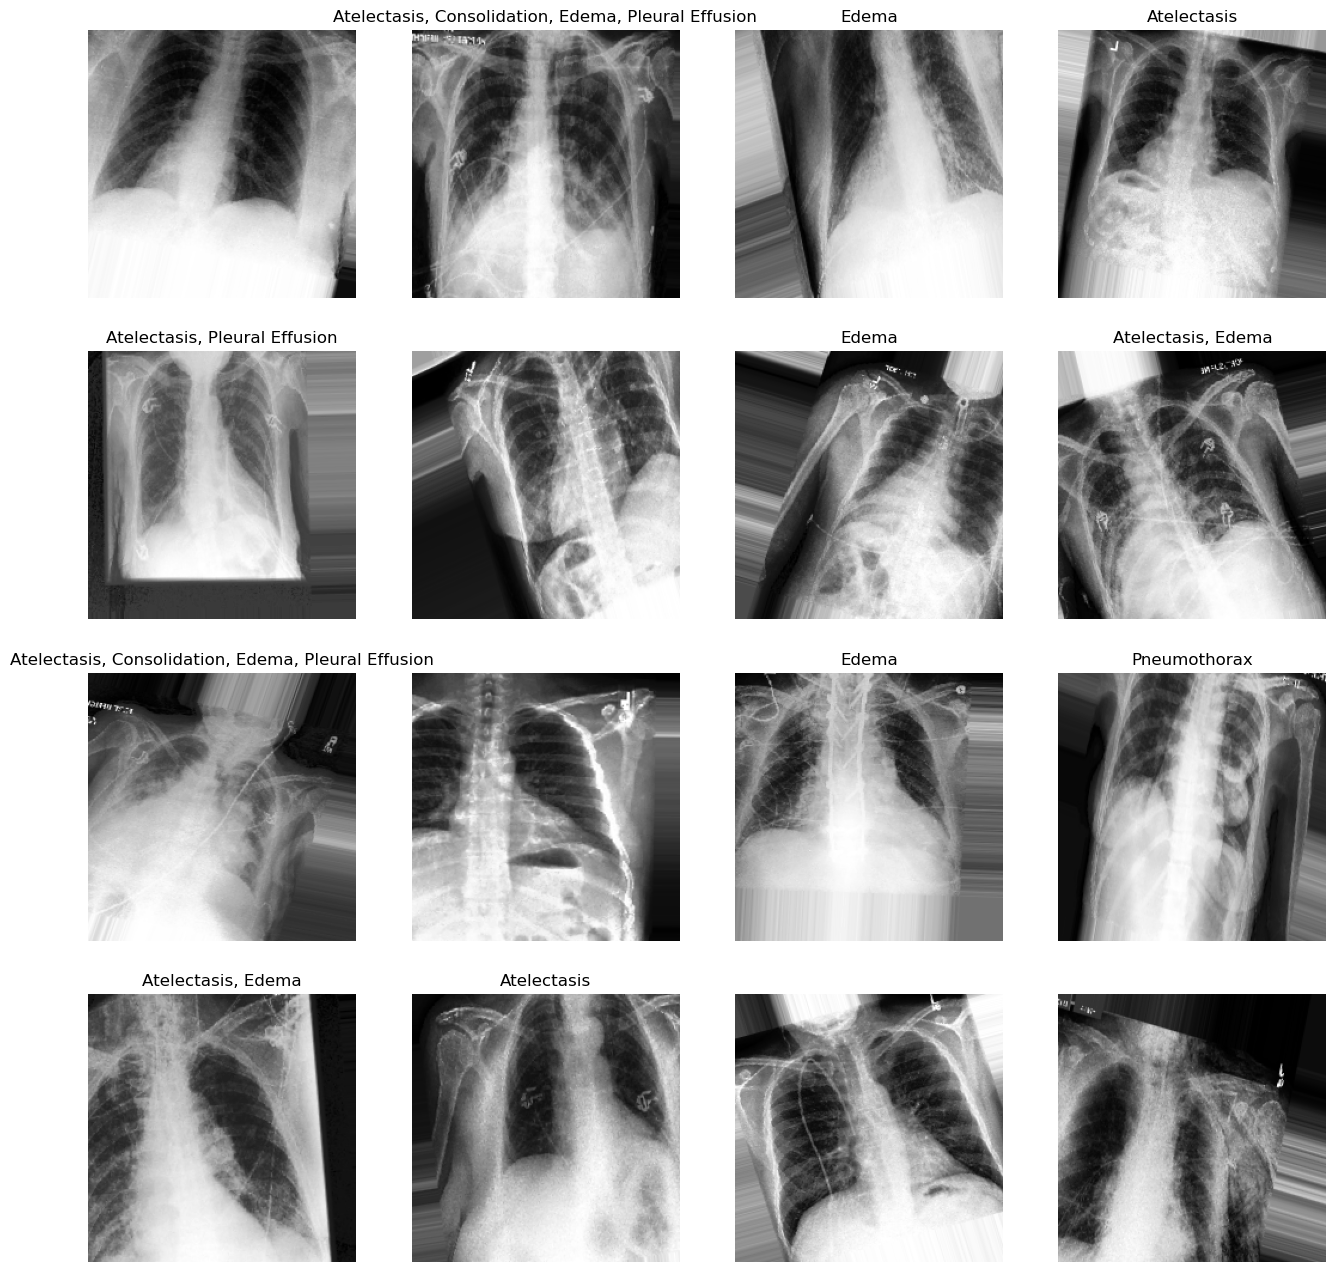

In [53]:
# import numpy as np
# import matplotlib.pyplot as plt

# t_x, t_y = next(valid_gen)
# fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
# for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
#     gray_x = np.dot(c_x[..., :3], [0.2989, 0.5870, 0.1140])
#     c_ax.imshow(gray_x, cmap='gray')
#     c_ax.set_title(', '.join([n_class for n_class, n_score in zip(class_names, c_y) 
#                              if n_score>0.5]))
#     c_ax.axis('off')


In [64]:
#model
base_model = DenseNet121(weights='/kaggle/input/densenet/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output  
x = GlobalAveragePooling2D()(x)
predictions = Dense(len(class_names), activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
#model.summary()

In [41]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [42]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [43]:
#optimizer = tf.optimizers.RMSProp(learning_rate=0.001)
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
    name='RMSprop'
)
model.compile(optimizer=optimizer, loss=macro_soft_f1, metrics=[macro_f1])

In [44]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [46]:
H = model.fit(train_gen,validation_data=(test_X,test_Y),epochs=1)

11940/11940 [==============================] - 5330s 446ms/step - loss: 0.6502 - macro_f1: 0.3516 - val_loss: 0.6928 - val_macro_f1: 0.3139


In [47]:
model.save('DenseNet121.h5')

In [48]:
def learning_curves(history):
    """Plot the learning curves of loss and macro f1 score 
    for the training and validation datasets.
    
    Args:
        history: history callback of fitting a tensorflow keras model 
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    macro_f1 = history.history['macro_f1']
    val_macro_f1 = history.history['val_macro_f1']
    
    epochs = len(loss)

    style.use("bmh")
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs+1), macro_f1, label='Training Macro F1-score')
    plt.plot(range(1, epochs+1), val_macro_f1, label='Validation Macro F1-score')
    plt.legend(loc='lower right')
    plt.ylabel('Macro F1-score')
    plt.title('Training and Validation Macro F1-score')
    plt.xlabel('epoch')

    plt.show()
    
    return loss, val_loss, macro_f1, val_macro_f1


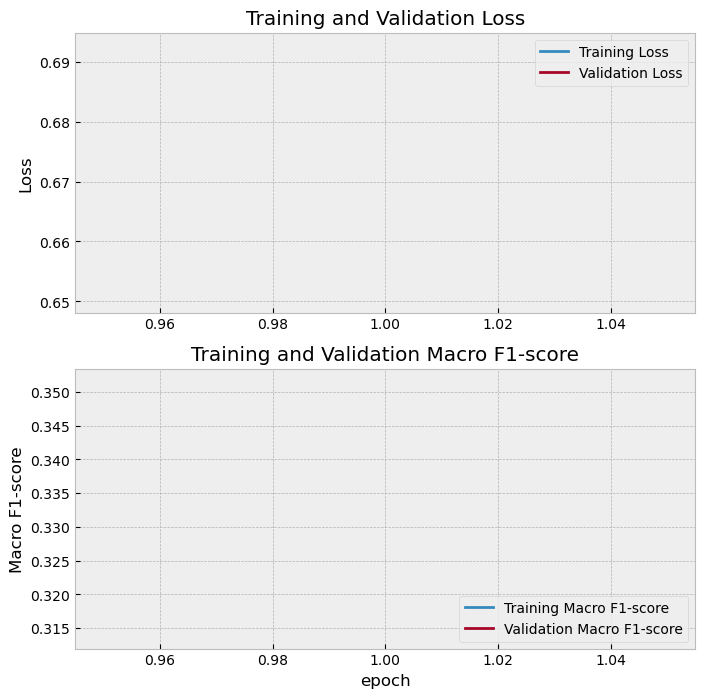

In [49]:
losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(H)

In [50]:
print("Macro soft-F1 loss: %.2f" %val_losses[-1])
print("Macro F1-score: %.2f" %val_macro_f1s[-1])

Macro soft-F1 loss: 0.69
Macro F1-score: 0.31


In [65]:
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

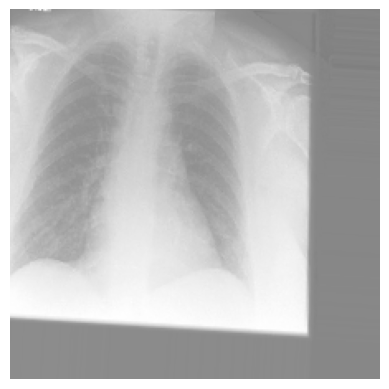

In [71]:
img_size = (224, 224)

img_array,_=next(valid_gen)
last_conv_layer_name = "conv5_block16_concat"
plt.axis("off")
plt.imshow((img_array[0]+1)/2)

In [72]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [73]:
preds = model.predict(img_array)
np.argmax(preds)

1/1 [==============================] - 12s 12s/step


30

In [74]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

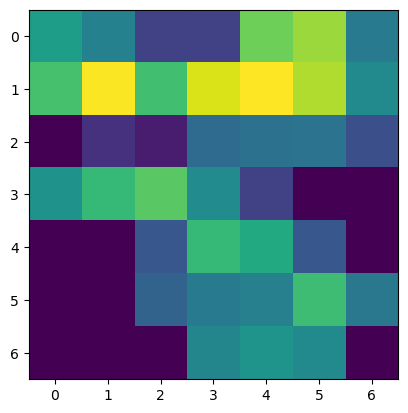

In [75]:
plt.imshow(heatmap)

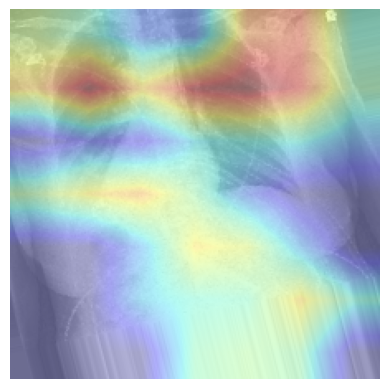

In [86]:
def save_and_display_gradcam(img_array, heatmap, alpha=0.4):
    # Load the original image
    
    img = (img_array[10] + 1)/2

    # Rescale heatmap to a range 0-255
    #heatmap = np.uint8(255 * heatmap)
    plt.imshow(img,alpha=1.0)
    plt.imshow(cv2.resize(heatmap,(224,224)),cmap='jet',alpha=0.3)
    plt.axis("off")
    plt.show()

    # Display Grad CAM
 


save_and_display_gradcam(img_array, heatmap)